In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output

from utils import dfwellgr,marker_ssig,extract_signature_Xy,recall_tops, find_optimal_tolerance
from utils import window, plot_pred_distribution

torch.manual_seed(42)
np.random.seed(42)


### LOAD Traing and Testing Data

In [2]:
#Load Prepared Training Data

X = np.load('prepared_data/X_201.npy')
y= np.load('prepared_data/y_201.npy')

# X = np.load('prepared_data/X_101.npy')
# y= np.load('prepared_data/y_101.npy')

# X = np.load('prepared_data/X_51.npy')
# y= np.load('prepared_data/y_51.npy')


In [3]:
#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

### Create DataLoader

In [4]:
#one hot for y 
y = np.eye(np.max(y) + 1)[y]

#nomralization for X
eps = 1e-6
f_mean = X.mean(axis=0)
f_std = X.std(axis=0) + eps  
X_norm= (X - f_mean) / f_std

#Split train & validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#Create dataloader
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32) 
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)  

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False)  

dataset_test = TensorDataset(X_valid_tensor, y_valid_tensor)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False) 

### Training FUNCTION

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_loss = float('inf')

    def early_stop(self, validation_loss):
        improvement = self.min_loss - validation_loss
        if improvement > self.min_delta:
            self.min_loss = validation_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [6]:
def train(num_epochs,model):
   
    start = time.time()
       
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.CrossEntropyLoss()
    early_stopper = EarlyStopper(patience=2,min_delta= 1e-4)

    for epoch in range(num_epochs):

        #========================TRAIN===========================#
        model.train()
        for i, (input_tensor, target_tensor) in enumerate(dataloader_train):
            input_tensor = input_tensor
            target_tensor = target_tensor.float()
            optimizer.zero_grad()

            output = model(input_tensor) 
            train_loss = criterion(output, target_tensor)

            train_loss.backward()
            
            optimizer.step()

        #========================EVALUATE===========================#
        num_correct = 0
        num_samples = 0
        model.eval()

        with torch.no_grad():
            for i, (input_tensor, target_tensor) in enumerate(dataloader_test):
                
                input_tensor = input_tensor
                target_tensor = target_tensor.float()
                output = model(input_tensor) 
  
                validation_loss = criterion(output, target_tensor)

                target_classes = target_tensor.long()
                target_classes = torch.argmax(target_classes, dim=1)
      
                pred_classes = torch.argmax(output, dim=1)

                num_correct += torch.sum(pred_classes == target_classes).item()
                current_batch_size = input_tensor.size(0) 
                num_samples += current_batch_size
            
            accuracy = num_correct / num_samples

            print(f'Epoch {epoch+1}/{num_epochs},   Training Loss:{train_loss.item():.5f},   Accuracy: {accuracy * 100:.2f}%,    Validation Loss: {validation_loss.item():.5f}')
            if epoch+1 > 5:
                if early_stopper.early_stop(validation_loss):  
                    print("Early Stop Triggered")           
                    break

    ext = time.time() - start
    print('Total training time',ext)
    return model

### THREE S2S Model

In [12]:
#import model
from s2s_model.BiGRUA import BiGRUAttn
from s2s_model.LSTMA import LSTMAttn
from s2s_model.ML_model import Attention,Encoder,Decoder,Seq2Seq
#impor testing func
from utlis_s2s import get_markers_rocket_order

#### BIGUA MODEL

In [13]:
input_size = X.shape[2]
hidden_size = 256
model = BiGRUAttn(input_size,hidden_size)
model=train(100,model)


Epoch 1/100,   Training Loss:0.75884,   Accuracy: 98.22%,    Validation Loss: 0.76585
Epoch 2/100,   Training Loss:0.74858,   Accuracy: 98.93%,    Validation Loss: 0.75044
Epoch 3/100,   Training Loss:0.74679,   Accuracy: 99.05%,    Validation Loss: 0.74754
Epoch 4/100,   Training Loss:0.74574,   Accuracy: 99.17%,    Validation Loss: 0.74633
Epoch 5/100,   Training Loss:0.74522,   Accuracy: 99.29%,    Validation Loss: 0.74590
Epoch 6/100,   Training Loss:0.74488,   Accuracy: 99.29%,    Validation Loss: 0.74527
Epoch 7/100,   Training Loss:0.74455,   Accuracy: 99.29%,    Validation Loss: 0.74495
Epoch 8/100,   Training Loss:0.74436,   Accuracy: 99.29%,    Validation Loss: 0.74476
Epoch 9/100,   Training Loss:0.74425,   Accuracy: 99.41%,    Validation Loss: 0.74470
Epoch 10/100,   Training Loss:0.74417,   Accuracy: 99.52%,    Validation Loss: 0.74455
Epoch 11/100,   Training Loss:0.74410,   Accuracy: 99.41%,    Validation Loss: 0.74443
Epoch 12/100,   Training Loss:0.74404,   Accuracy: 9

In [ ]:
torch.save(model, 'saved_model/bigu_model.pth')
torch.save(model.state_dict(), 'saved_model/bigu_model_state.pth')

## Load the model
# model = torch.load('bigu_model.pth')
# model.load_state_dict(torch.load('bigu_model_state.pth'))

#### Testing

Prediction:[6595, 6842, 6856]
Real:[6604.0, 6845.0, 6868.0]


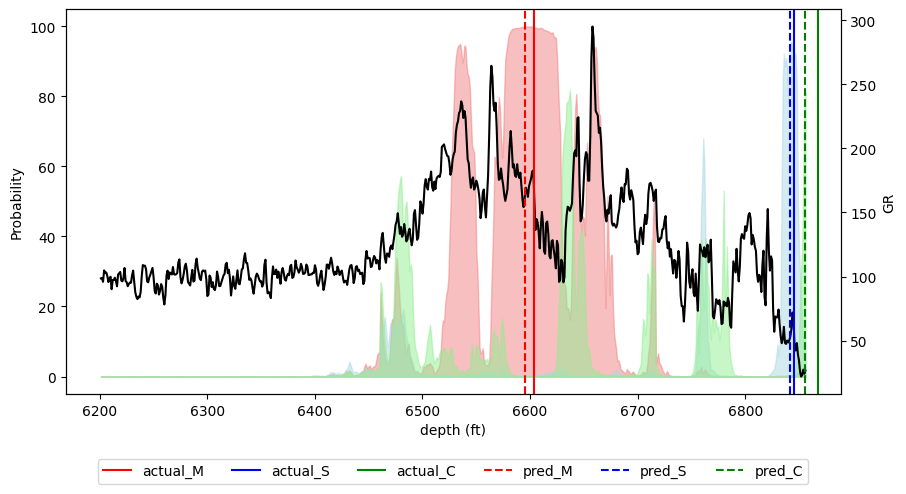

In [14]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize = 201 #adjust as needed
well =  512329241
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model,constraints=True)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [24]:
#Predict ALL WITHOUT CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model,constraints=True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 22.15753698348999


In [27]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9866666666666667, mae 3.8066666666666666
tolerance 15, recall 0.9866666666666667, mae 3.8066666666666666
tolerance 10, recall 0.94, mae 3.8066666666666666
tolerance 5, recall 0.7733333333333333, mae 3.8066666666666666
Largest Error MARCEL: 22.0
Largest Error SYLVAIN: 22.0
Largest Error CONRAD: 12.0
Optimal Tolerance : 22


#### LSTM Model 

In [15]:
input_size = X.shape[2]
hidden_size = 128
output_dim = 100
model = LSTMAttn(input_size,hidden_size,output_dim)
model=train(100,model)

Epoch 1/100,   Training Loss:1.04556,   Accuracy: 94.06%,    Validation Loss: 1.32730
Epoch 2/100,   Training Loss:0.81633,   Accuracy: 97.86%,    Validation Loss: 0.76737
Epoch 3/100,   Training Loss:0.77724,   Accuracy: 99.05%,    Validation Loss: 0.75269
Epoch 4/100,   Training Loss:0.76239,   Accuracy: 99.17%,    Validation Loss: 0.74947
Epoch 5/100,   Training Loss:0.75659,   Accuracy: 99.29%,    Validation Loss: 0.74756
Epoch 6/100,   Training Loss:0.75309,   Accuracy: 99.29%,    Validation Loss: 0.74644
Epoch 7/100,   Training Loss:0.75103,   Accuracy: 99.17%,    Validation Loss: 0.74553
Epoch 8/100,   Training Loss:0.74977,   Accuracy: 99.17%,    Validation Loss: 0.74516
Epoch 9/100,   Training Loss:0.74855,   Accuracy: 99.29%,    Validation Loss: 0.74478
Epoch 10/100,   Training Loss:0.74777,   Accuracy: 99.41%,    Validation Loss: 0.74461
Epoch 11/100,   Training Loss:0.74710,   Accuracy: 99.41%,    Validation Loss: 0.74442
Epoch 12/100,   Training Loss:0.74690,   Accuracy: 9

In [ ]:
torch.save(model, 'saved_model/lstm_model.pth')
torch.save(model.state_dict(), 'saved_model/lstm_model_state.pth')

## Load the model
# model = torch.load('bigu_model.pth')
# model.load_state_dict(torch.load('bigu_model_state.pth'))

#### Testing

Prediction:[6286, 6513, 6542]
Real:[6283.0, 6518.0, 6543.0]


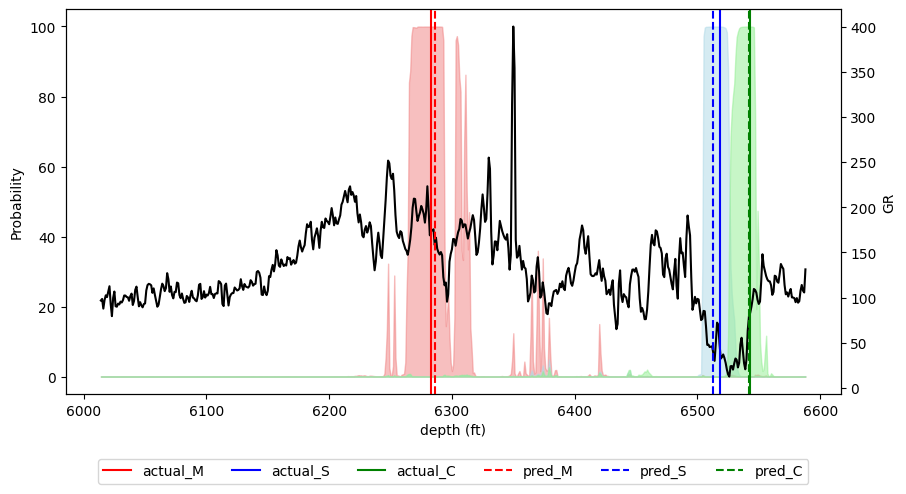

In [16]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize = 201 #adjust as needed
well = 512330506
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model,constraints=True)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [20]:
#Predict ALL WITH CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model,constraints=True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 16.9296772480011


In [21]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9933333333333333, mae 3.4166666666666665
tolerance 15, recall 0.9933333333333333, mae 3.4166666666666665
tolerance 10, recall 0.9466666666666667, mae 3.4166666666666665
tolerance 5, recall 0.7733333333333333, mae 3.4166666666666665
Largest Error MARCEL: 30.0
Largest Error SYLVAIN: 12.0
Largest Error CONRAD: 13.0
Optimal Tolerance : 30


#### ML Model

In [17]:
input_size = X.shape[2]
hidden_size = 128
num_layers = 2
output_size = 100
conv_output_dim = 64
dense_output_dim = 128
num_classes = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Instantiate model
attention = Attention(hidden_size)
encoder = Encoder(input_size, hidden_size, num_layers)
decoder = Decoder(output_size, hidden_size, num_layers, attention)
model = Seq2Seq(encoder, decoder, conv_output_dim, dense_output_dim, num_classes,device).to(device)

In [18]:
model = train(100,model)

Epoch 1/100,   Training Loss:1.14931,   Accuracy: 51.43%,    Validation Loss: 1.22921
Epoch 2/100,   Training Loss:0.92966,   Accuracy: 83.73%,    Validation Loss: 0.87743
Epoch 3/100,   Training Loss:0.81414,   Accuracy: 99.05%,    Validation Loss: 0.79205
Epoch 4/100,   Training Loss:0.75562,   Accuracy: 99.05%,    Validation Loss: 0.75484
Epoch 5/100,   Training Loss:0.74890,   Accuracy: 99.17%,    Validation Loss: 0.74885
Epoch 6/100,   Training Loss:0.74682,   Accuracy: 99.29%,    Validation Loss: 0.74681
Epoch 7/100,   Training Loss:0.74574,   Accuracy: 97.03%,    Validation Loss: 0.84408
Epoch 8/100,   Training Loss:0.74514,   Accuracy: 99.17%,    Validation Loss: 0.74509
Epoch 9/100,   Training Loss:0.74473,   Accuracy: 99.05%,    Validation Loss: 0.74474
Epoch 10/100,   Training Loss:0.74448,   Accuracy: 99.17%,    Validation Loss: 0.74449
Epoch 11/100,   Training Loss:0.74431,   Accuracy: 99.05%,    Validation Loss: 0.74432
Epoch 12/100,   Training Loss:0.74418,   Accuracy: 9

Prediction:[6315, 6557, 6583]
Real:[6329.0, 6564.0, 6587.0]


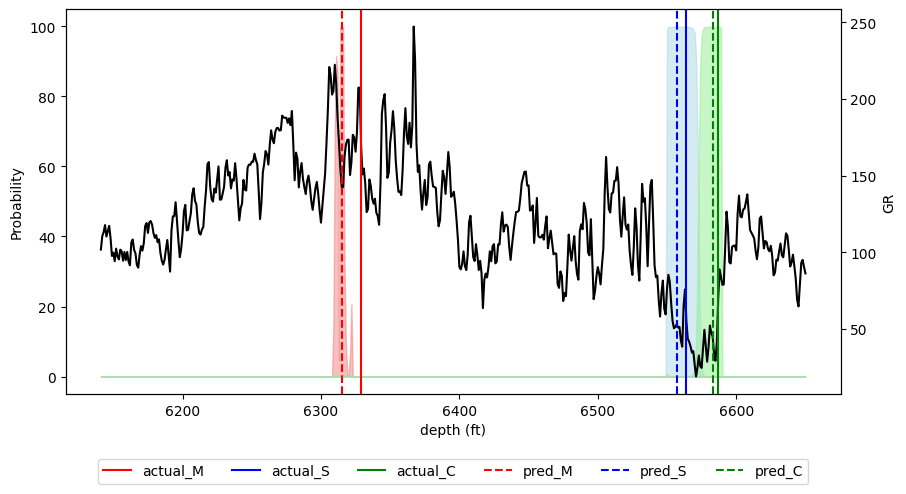

In [11]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize = 201 #adjust as needed
well = 512331401
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model,constraints=True)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [12]:
#Predict ALL WITHOUT CONSTRAINTS

start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, model,constraints=True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 70.95645189285278


In [13]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 1.0, mae 3.3733333333333335
tolerance 15, recall 0.9866666666666667, mae 3.3733333333333335
tolerance 10, recall 0.96, mae 3.3733333333333335
tolerance 5, recall 0.82, mae 3.3733333333333335
Largest Error MARCEL: 17.0
Largest Error SYLVAIN: 17.0
Largest Error CONRAD: 14.0
Optimal Tolerance : 17


#### BIGUA MODEL